In [38]:
import sys
sys.path.insert(0, "/home/robin/projects/Bachelorthesis")

import numpy as np
import torch
from envs.robots.ccd import IK
from supervised.train import forward_kinematics
import matplotlib.pyplot as plt



(50, 3)
(50, 2)
(50, 2)


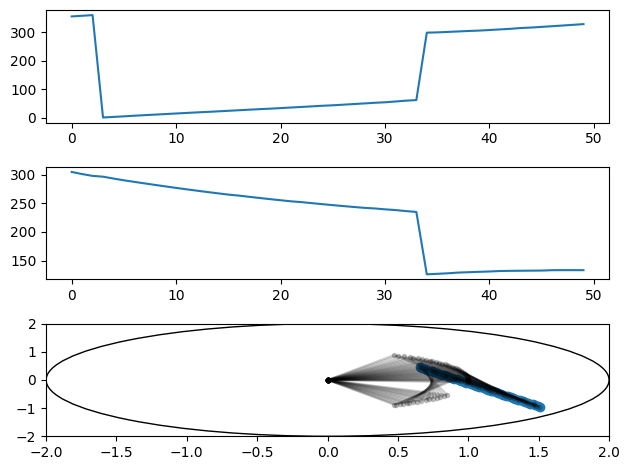

In [46]:
np.random.seed(2344)


def create_line_data():
    link = np.ones(2)
    num_points = 50

    # create line in 2pi box
    start = np.array([-np.pi, np.random.uniform(-np.pi, np.pi)])
    end = np.array([np.pi, np.random.uniform(-np.pi, np.pi)])
    angles = np.linspace(start, end, num_points)
    angles = np.zeros_like(angles)

    # create target line
    angle = np.random.uniform(0, 2 * np.pi, size=(2))
    radius = np.random.uniform(0, 2, size=(2))
    start = np.zeros(3)
    start[0] = np.cos(angle[0]) * radius[0]
    start[1] = np.sin(angle[0]) * radius[0]
    end = np.zeros(3)
    end[0] = np.cos(angle[1]) * radius[1]
    end[1] = np.sin(angle[1]) * radius[1]
    targets = np.linspace(start, end, num_points)
    # targets = targets[1].repeat(100)

    # solve with ik
    print(targets.shape)
    print(angles.shape)
    return angles, targets, np.stack([IK(target, angle, link, err_min=0.01)[0] for angle, target in zip(angles, targets)])


start_angles, targets, sol_angles = create_line_data()

fig, axes = plt.subplots(3, 1, tight_layout=True)
axes = axes.flatten()

axes[0].plot(sol_angles[:, 0])
axes[1].plot(sol_angles[:, 1])

circle = plt.Circle((0, 0), 2, fill=False)
axes[2].add_patch(circle)
axes[2].set_xlim([-2, 2])
axes[2].set_ylim([-2, 2])
axes[2].scatter(targets[:, 0], targets[:, 1])

sol_angles = sol_angles / 180 * np.pi
sol_angles = np.cumsum(sol_angles, axis=1)
print(sol_angles.shape)
arm_positions = forward_kinematics(torch.tensor(sol_angles))
for position_sequence in arm_positions:
    axes[2].plot(position_sequence[:, 0], position_sequence[:, 1], color="k", marker=".", alpha=1/5)
    


(100, 3)
(100, 2)


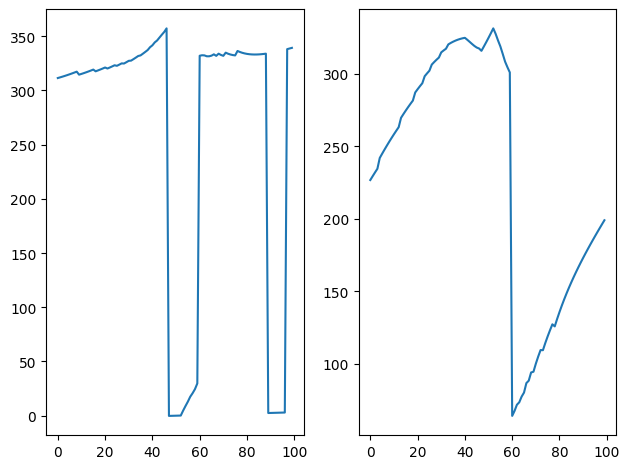

In [ ]:
import torch


def create_line_data():
    link = np.ones(2)

    # create line in 2pi box
    start = np.array([-np.pi, np.random.uniform(-np.pi, np.pi)])
    end = np.array([np.pi, np.random.uniform(-np.pi, np.pi)])
    angles = np.linspace(start, end, 100)

    # create delta line
    t = np.linspace(-np.pi, np.pi, 100)
    delta = np.stack([np.sin(t), np.cos(t)]).T * 0.0

    # calculate target positions
    targets = np.zeros((100, 3))
    targets[:, :2] = forward_kinematics(torch.tensor(angles)).numpy()[:, -1] + delta
    print(targets.shape)
    print(angles.shape)

    # solve with ik
    return angles, np.stack([IK(target, angle, link, err_min=0.001)[0] for angle, target in zip(angles.copy(), targets)])


start_angles, sol_angles = create_line_data()

fig, axes = plt.subplots(1, 2, tight_layout=True)
axes = axes.flatten()

axes[0].plot(sol_angles[:, 0])
axes[1].plot(sol_angles[:, 1])

In [ ]:
start_angles.shape

(100, 2)

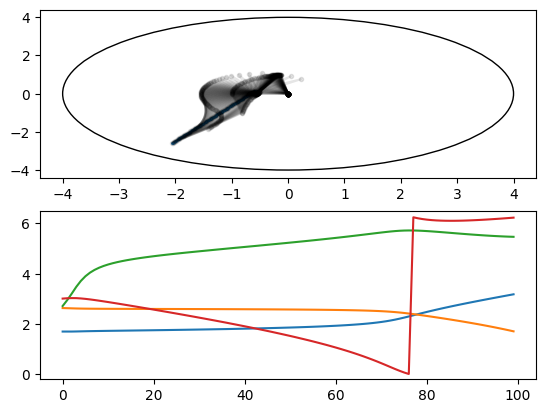

In [140]:
def create_trajectory(num_points: int, num_joints: int):
    angle = np.random.uniform(0, 2 * np.pi, size=(2))
    radius = np.random.uniform(0, num_joints, size=(2))
    start = np.zeros(3)
    start[0] = np.cos(angle[0]) * radius[0]
    start[1] = np.sin(angle[0]) * radius[0]
    end = np.zeros(3)
    end[0] = np.cos(angle[1]) * radius[1]
    end[1] = np.sin(angle[1]) * radius[1]
    targets = np.linspace(start, end, num_points)

    return targets

num_points = 100
num_joints = 4
trajectory = create_trajectory(num_points, num_joints)
# plot trajectory 
fig, axs = plt.subplots(2, 1)
# draw circle with trajectory
axs[0].add_patch(plt.Circle((0, 0), num_joints, fill=False))
axs[0].scatter(trajectory[:, 0], trajectory[:, 1], s=1)

link = np.ones(num_joints)
rel_angle = np.zeros(num_joints)
rel_angles = []
for target in trajectory:
    rel_angle, _, _, _ = IK(target, rel_angle, link, err_min=0.001)
    rel_angles.append(rel_angle.copy() / 180 * np.pi)
    
rel_angles = np.stack(rel_angles)
abs_angles = np.cumsum(rel_angles, axis=1)
arm_positions = forward_kinematics(torch.tensor(abs_angles))
for position_sequence in arm_positions:
    axs[0].plot(position_sequence[:, 0], position_sequence[:, 1], color="k", marker=".", alpha=1/10)

axs[1].set_ylim([-0.2, 2 * np.pi + 0.2])
for i in range(num_joints):
    axs[1].plot(rel_angles[:, i])